# 라이브러리 임포트

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
from torch.autograd import Variable

from bs4 import BeautifulSoup
from selenium import webdriver
from pykrx import stock

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from tqdm.auto import tqdm
import sweetviz as sv
from sklearn.preprocessing import MinMaxScaler

import matplotlib

import datetime as dt, itertools

scaler = MinMaxScaler()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   #'cuda:0, cuda:1, cuda:2'

# 자료 전처리

In [2]:
path = os.getcwd()
src = ['280429', '281219', '854470']  # UNID의 주요 원자재 정의
terms = ['1409-1809', '1810-2210']  # 조회한 기간
src_name = {
    '280429' : '헬륨가스',
    '281219' : '규안화수소',
    '854470' : '광섬유케이블'
}
src_name

{'280429': '헬륨가스', '281219': '규안화수소', '854470': '광섬유케이블'}

In [3]:
# 칼륨계 수출입 자료 로드
def load_trade_csv(code, term):
    try :  # utf-8로 디코딩된 csv 로드
        df = pd.read_csv(path + f'/data/{code}_{term}.csv', encoding = 'utf-8', skipinitialspace = True)
    except :  # euc-kr로 디코딩 csv 로드
        df = pd.read_csv(path + f'/data/{code}_{term}.csv', encoding = 'euc-kr', skipinitialspace = True)
    # yyyy-mm 방식의 월단위로 datetime 자료형 정렬
    df['기간'] = pd.to_datetime(df['기간'].map('{:.2f}'.format), format='%Y.%m').dt.strftime('%Y-%m')
    # 한글 컬럼명을 영어로 변경 _name : 해당 원소명, _exp : 수출, _imp : 수입, _weight : 중량, _sum : 금액, _margin : 수지
    df.columns = [f'date', f'{code}_name', f'{code}_code', f'{code}_exp_weight', f'{code}_imp_weight', f'{code}_exp_sum', f'{code}_imp_sum', f'{code}_margin']
    df.set_index('date', drop = True, append = False, inplace = True)
    return df

# 수출입데이터(수출입 중량, 수출입 금액, 수지) 스케일링
def preprocessing(src_df) : 
    for a, code in enumerate(src) :
        src_df = src_df.drop([f'{code}_name', f'{code}_code'], axis = 1)  # 날짜를 인덱스로 학습용 데이터 추출
        # 0 ~ 1 로 MinMaxScaling
        src_df.loc[:, f'{code}_exp_weight':f'{code}_margin'] = scaler.fit_transform(src_df.loc[:, f'{code}_exp_weight':f'{code}_margin'].astype(float))
    return src_df

# 종목 종가 스크리닝
def read_stock(df, code):
    # 수출입데이터의 시작월과 종료월 추출
    dt_pst, dt_now = df.index[0].replace('-', '')+'01', df.index[-1].replace('-', '')+'28'
    # 추출한 시작월부터 종료월 기간까지 UNID 월별 주가 추출
    company = stock.get_market_ohlcv(dt_pst, dt_now, code, freq = 'm')
    company.index = df.index  # 날짜 인덱스 자료형 통일
    print(company)
    company = pd.DataFrame({'close' : company['종가']})  # 종가만 추출
    return company

In [4]:
# 숫자 데이터 전처리
for a, code in enumerate(src) :
    for b, term in enumerate(terms) :
        print(code, term)
        if b == 0 :
            src_df = load_trade_csv(code, term)
        elif term == '1409-1809' :  # 자료 단위가 5개년이므로 과거자료를 위에
            src_df = pd.concat([src_df, load_trade_csv(code, term)], axis = 1, join = 'inner')
        elif term == '1810-2210' :  # 최근자료를 아래에 붙임으로 날짜 내림차순으로 정렬
            src_df = pd.concat([src_df, load_trade_csv(code, term)], axis = 0, join = 'inner')
        for c in range(len(src_df.columns)):  # 
            try :
                src_df.iloc[:, c] = src_df.iloc[:, c].str.strip()  # 문자열 내 공백을 제거
                src_df.iloc[:, c] = src_df.iloc[:, c].str.replace(',', '')  # 천단위 구분자 ',' 제거
            except : 
                pass
    if a == 0 :
        df = src_df
    else :
        df = pd.concat([df, src_df], axis = 1, join = 'inner')
        
src = preprocessing(df)
dst = read_stock(src, '010170')

# 수출입데이터와 유니드 주가 결합
data = pd.concat([src, dst], axis=1)

# 주가 상승 시 1, 하락시 0으로 Target Column 생성
data['tgt'] = 0.5
for i in range(len(data)):
    if i == len(data) - 1:
        break
    else :
        if data['close'][i+1] - data['close'][i] > 0 :
            data['tgt'][i] = 1
        else :
            data['tgt'][i] = 0
data = data.fillna(0)

280429 1409-1809
280429 1810-2210
281219 1409-1809
281219 1810-2210
854470 1409-1809
854470 1810-2210
           시가    고가    저가    종가       거래량
date                                     
2014-09  1027  1027   964   984   1013569
2014-10   978   998   824   984   1916660
2014-11   983  1051   875   916   2215409
2014-12   923   932   826   841   1957903
2015-01   846   916   829   881    887887
...       ...   ...   ...   ...       ...
2022-06  2495  2810  2000  2275  19437142
2022-07  2245  2755  2030  2550  13028497
2022-08  2550  3350  2500  2790  33051223
2022-09  2755  3375  2410  2625  27009678
2022-10  2645  2790  2300  2485  10606958

[98 rows x 5 columns]


C:\Users\chanw\AppData\Local\Temp\ipykernel_1448\1147567879.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tgt'][i] = 0
C:\Users\chanw\AppData\Local\Temp\ipykernel_1448\1147567879.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tgt'][i] = 1


In [5]:
data

,280429_exp_weight,280429_imp_weight,280429_exp_sum,280429_imp_sum,280429_margin,281219_exp_weight,281219_imp_weight,281219_exp_sum,281219_imp_sum,281219_margin,854470_exp_weight,854470_imp_weight,854470_exp_sum,854470_imp_sum,854470_margin,close,tgt
date,,,,,,,,,,,,,,,,,
2014-09,0.444444,0.186674,0.203943,0.053386,0.998035,0.000000,0.000000,0.000000,0.000000,0.202208,0.274529,0.031920,0.238916,0.025239,0.722215,984,0.0
2014-10,0.216802,0.225220,0.117757,0.081426,0.931004,0.000000,0.000000,0.000000,0.000000,0.202208,0.499065,0.096029,0.431865,0.117090,0.741139,984,0.0
2014-11,0.078591,0.132709,0.049820,0.059006,0.923443,0.000000,0.000000,0.000000,0.000000,0.202208,0.316877,0.034284,0.259899,0.065080,0.702179,916,0.0
2014-12,0.067751,0.504956,0.041694,0.251010,0.724551,0.000000,0.000000,0.000000,0.000000,0.202208,0.414038,0.032887,0.322998,0.154528,0.664398,841,1.0
2015-01,0.334688,0.196586,0.191954,0.113973,0.931063,0.000000,0.000000,0.000000,0.000000,0.202208,0.249678,0.077919,0.196307,0.060453,0.676962,881,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06,0.174797,0.234031,0.191421,0.394252,0.645791,0.091436,0.076537,1.000000,0.698585,1.000000,0.337032,0.000000,0.385603,0.093714,0.737603,2275,1.0
2022-07,0.200542,0.686674,0.228453,0.746063,0.304560,0.060528,0.565232,0.773409,0.757783,0.664994,0.384906,0.000000,0.518762,0.185986,0.729286,2550,1.0
2022-08,0.139566,0.568833,0.181431,0.703506,0.326825,0.063104,0.271479,0.668908,0.761792,0.527011,0.363712,0.000000,0.425644,0.177483,0.693640,2790,0.0


In [6]:
# 보조 학습 데이터 로드
extras = ['KR10Y', 'USD_KRW', 'EUR_KRW', 'HGZ2']  # 한국10년물 수익률, 달러/원, 유로/원, 구리선물
for i, extra in enumerate(extras) :
    if extra != 'CCUS' :  # 인베스팅닷컴 자료는 역순으로 저장되어 있으므로 역순하여 로드
        csv = pd.read_csv(path + f'/data/{extra}_1409-2210.csv').loc[::-1].reset_index(drop=True).iloc[:,1]
    elif extra == 'CCUS' :  # 구글 트렌드 자료 로드
        csv = pd.read_csv(path + f'/data/{extra}_1409-2210.csv').reset_index(drop=True).iloc[:,1]
    
    try :  # 천단위 구분자 ',' 제거
        csv = csv.str.replace(',', '')
    except :
        pass
    
    temp = pd.concat([csv, pd.Series(data.index)], axis=1).set_index('date')  # 기존 자료 인덱스로 정리
    
    if extra != 'CCUS' :
        temp.columns = [f'{extra}_close']  # 금융 데이터는 종가만 추출하고 컬럼명 정의
    elif extra == 'CCUS' :
        temp.columns = [f'{extra}_interest']  # 구글 트렌드 자료 컬럼명 정의
    if i == 0 :
        df = temp
    else :
        df = pd.concat([df, temp], axis=1)
        
df.iloc[:,:] = scaler.fit_transform(df)  # 0 ~ 1 로 MinMaxScaling
data = pd.concat([data.iloc[:, :-2], df, data.iloc[:, -2:]], axis=1)  # Target 컬럼 앞에 삽입
data

,280429_exp_weight,280429_imp_weight,280429_exp_sum,280429_imp_sum,280429_margin,281219_exp_weight,281219_imp_weight,281219_exp_sum,281219_imp_sum,281219_margin,...,854470_imp_weight,854470_exp_sum,854470_imp_sum,854470_margin,KR10Y_close,USD_KRW_close,EUR_KRW_close,HGZ2_close,close,tgt
date,,,,,,,,,,,,,,,,,,,,,
2014-09,0.444444,0.186674,0.203943,0.053386,0.998035,0.000000,0.000000,0.000000,0.000000,0.202208,...,0.031920,0.238916,0.025239,0.722215,0.532193,0.000000,0.624858,0.355322,984,0.0
2014-10,0.216802,0.225220,0.117757,0.081426,0.931004,0.000000,0.000000,0.000000,0.000000,0.202208,...,0.096029,0.431865,0.117090,0.741139,0.459423,0.046833,0.674277,0.369919,984,0.0
2014-11,0.078591,0.132709,0.049820,0.059006,0.923443,0.000000,0.000000,0.000000,0.000000,0.202208,...,0.034284,0.259899,0.065080,0.702179,0.440644,0.150230,0.856239,0.299335,916,0.0
2014-12,0.067751,0.504956,0.041694,0.251010,0.724551,0.000000,0.000000,0.000000,0.000000,0.202208,...,0.032887,0.322998,0.154528,0.664398,0.446680,0.099504,0.581551,0.288064,841,1.0
2015-01,0.334688,0.196586,0.191954,0.113973,0.931063,0.000000,0.000000,0.000000,0.000000,0.202208,...,0.077919,0.196307,0.060453,0.676962,0.324279,0.121559,0.236488,0.166112,881,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06,0.174797,0.234031,0.191421,0.394252,0.645791,0.091436,0.076537,1.000000,0.698585,1.000000,...,0.000000,0.385603,0.093714,0.737603,0.792757,0.604447,0.701563,0.614930,2275,1.0
2022-07,0.200542,0.686674,0.228453,0.746063,0.304560,0.060528,0.565232,0.773409,0.757783,0.664994,...,0.000000,0.518762,0.185986,0.729286,0.621060,0.644560,0.622108,0.565041,2550,1.0
2022-08,0.139566,0.568833,0.181431,0.703506,0.326825,0.063104,0.271479,0.668908,0.761792,0.527011,...,0.000000,0.425644,0.177483,0.693640,0.829645,0.743727,0.698332,0.544346,2790,0.0


# 수집 데이터와 분석 종목과의 주가 plot

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


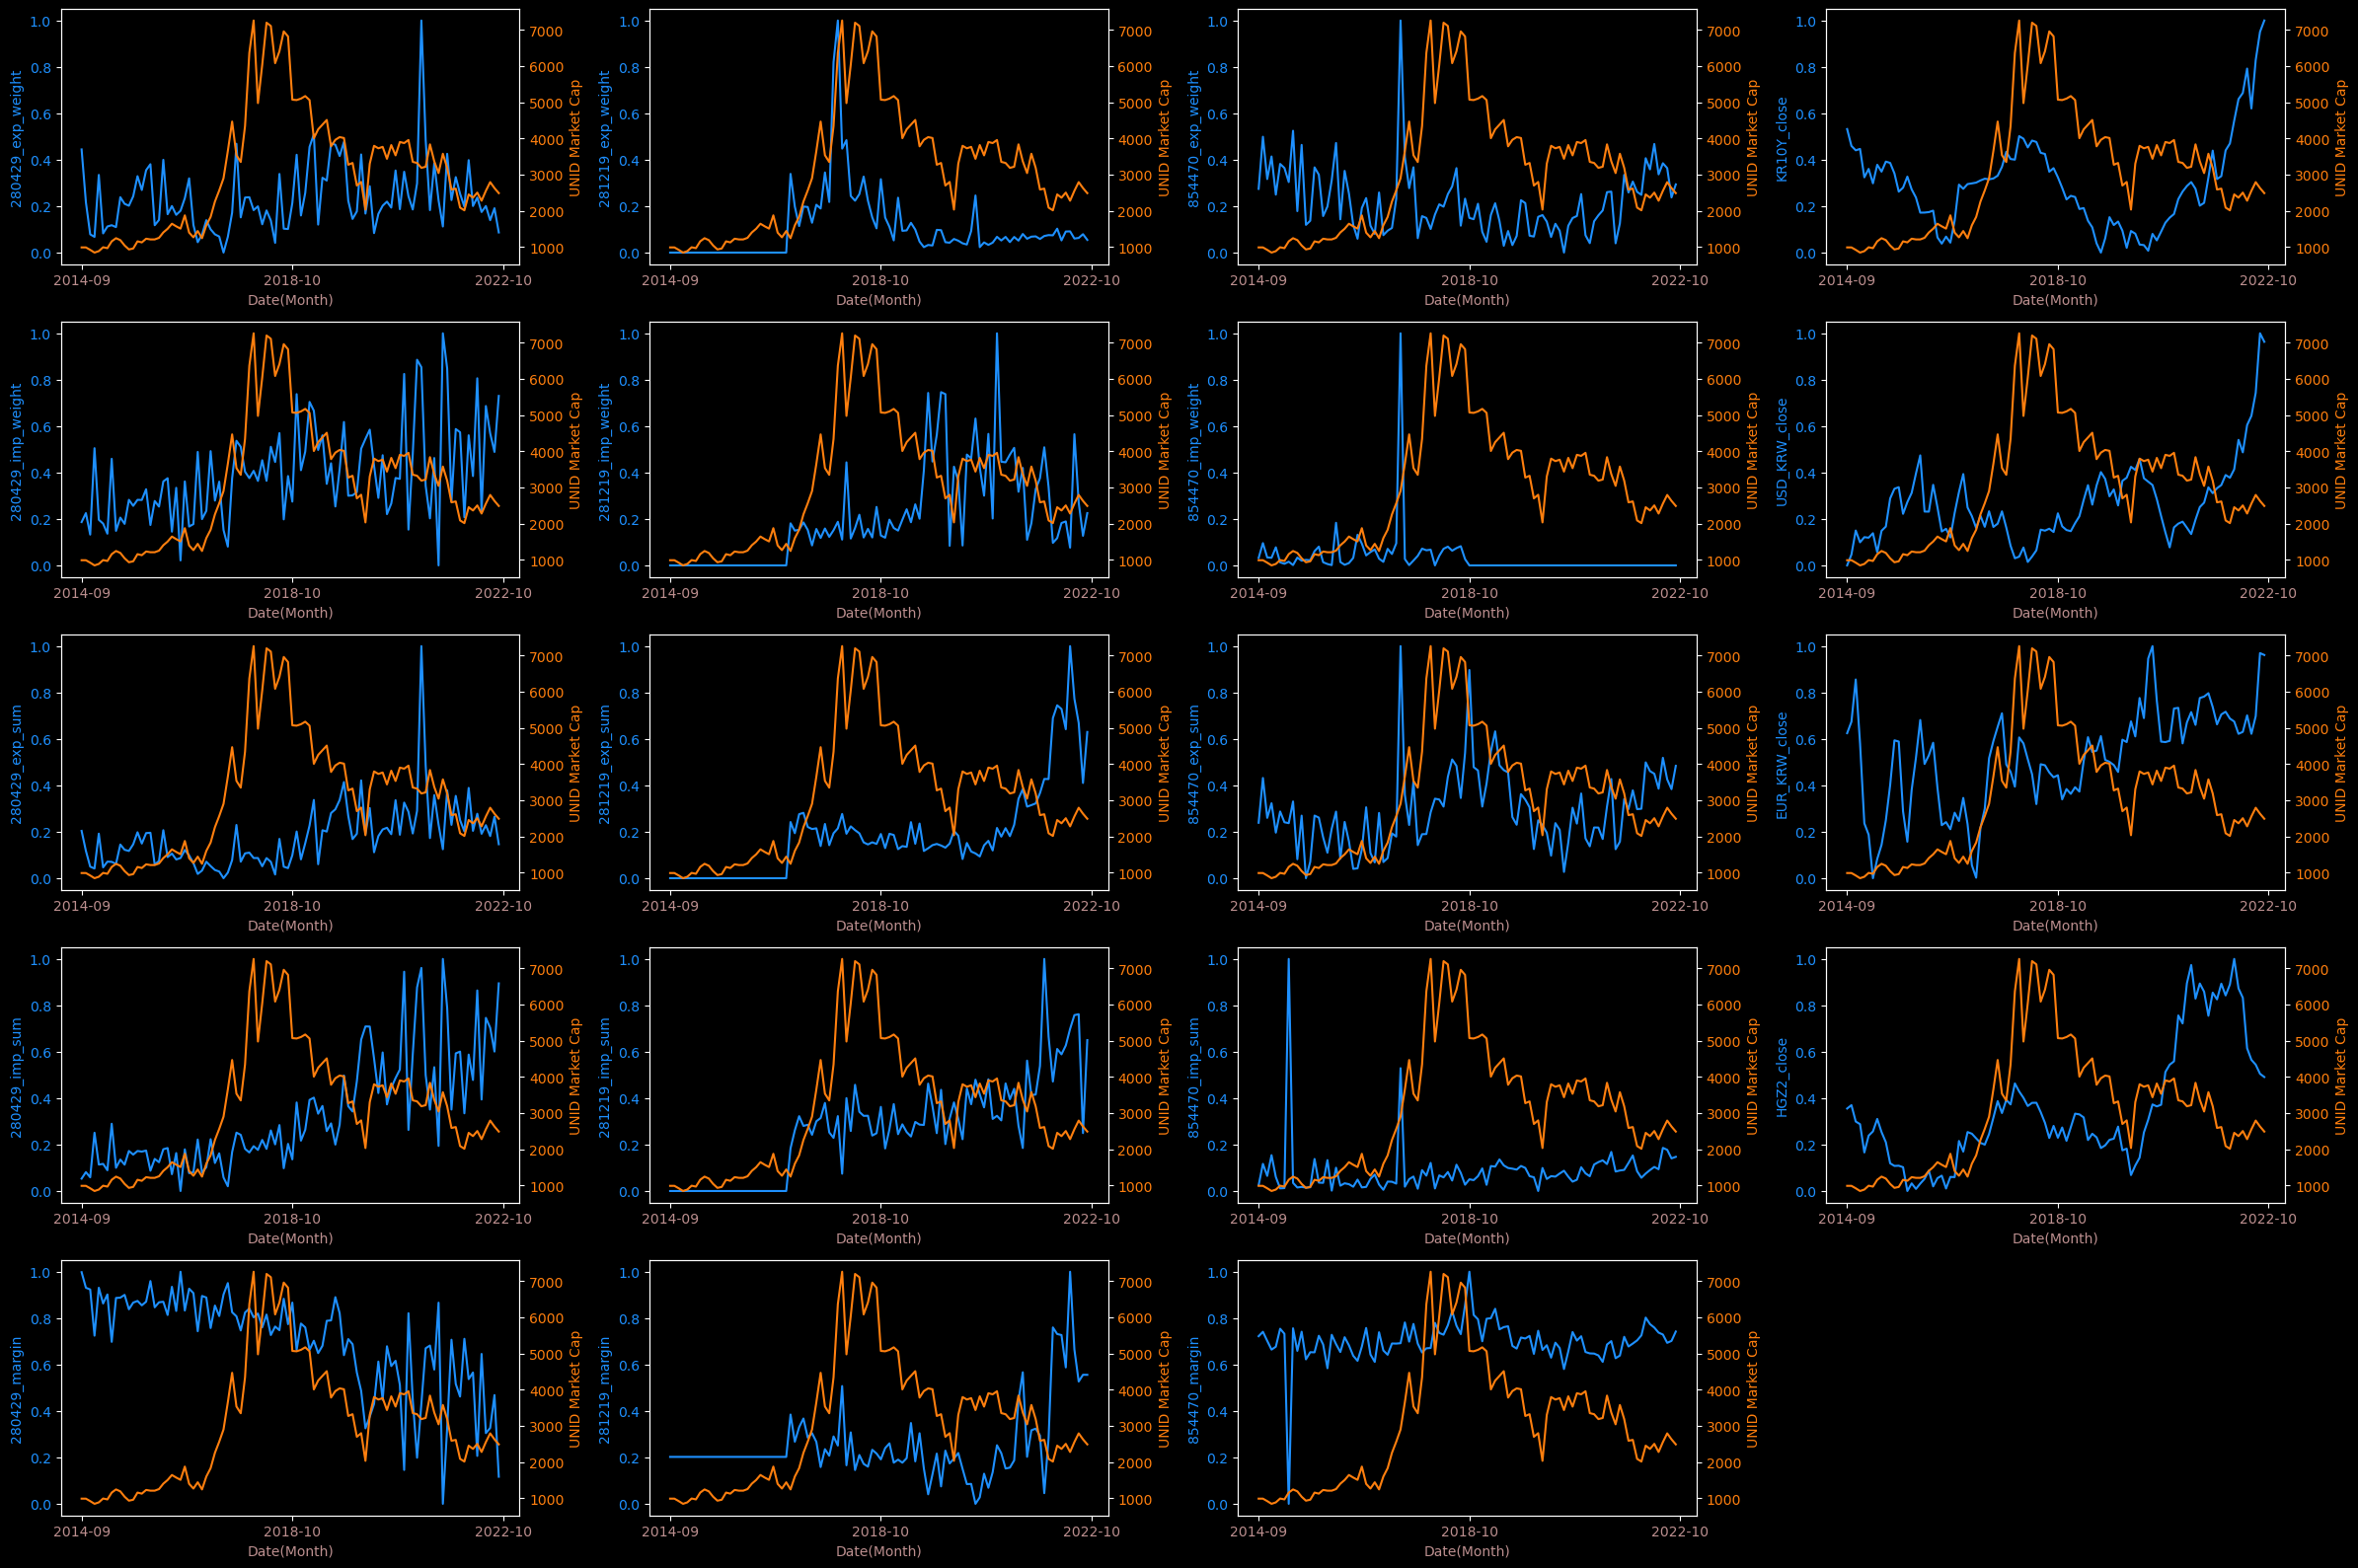

In [7]:
color_0, color_1, color_2, color_3 = 'rosybrown', 'dodgerblue', 'tab:orange', 'limegreen'  # darkmode : mistyrose, # lightmode : rosybrown
plt.figure(figsize=(24,16), facecolor='black')
for i in range(len(data.columns)-2) :
    from matplotlib import style
    style.use('dark_background')
    row, col = 5, 4
    r = i % row
    c = i // row
    #print(f'r : {r}, c : {c}, column = {data.columns[i]}, location : {(r*4)+(c+1)}')
    ax1 = plt.subplot(row, col, (r*4)+(c+1))
    plt.xticks([0, len(data.index)//2, len(data.index)], labels=[data.index[0], data.index[len(data.index)//2], data.index[-1]])
    ax1.set_xlabel('Date(Month)', color=color_0)
    ax1.tick_params(axis='x', labelcolor=color_0)
    ax1.set_ylabel(data.columns[i], color=color_1)
    ax1.plot(data.index, data.iloc[:,i], color=color_1, label=data.columns[i])
    ax1.tick_params(axis='y', labelcolor=color_1)
    ax2 = ax1.twinx()
    ax2.set_ylabel('UNID Market Cap', color=color_2)
    ax2.plot(data.index, data.iloc[:,-2], color=color_2, label='UNID Market Cap')
    ax2.tick_params(axis='y', labelcolor=color_2)
    #ax1.legend()
    #ax2.legend()
plt.tight_layout()
plt.show()

# 상관관계와 통계량 분석을 위한 SweetViz 자동화 EDA 툴 구동

In [8]:
sv.analyze(data, 'close').show_html('./THFiber_report.html')

                                             |                                             | [  0%]   00:00 ->…

C:\Users\chanw\anaconda3\lib\site-packages\sweetviz\graph_associations.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.Series(empty_row_dict, name=feature))
C:\Users\chanw\anaconda3\lib\site-packages\sweetviz\graph_associations.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.Series(empty_row_dict, name=feature))
C:\Users\chanw\anaconda3\lib\site-packages\sweetviz\graph_associations.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.Series(empty_row_dict, name=feature))
C:\Users\chanw\anaconda3\lib\site-packages\sweetviz\graph_associations.py:223: FutureWarning: The frame.append method is dep

Report ./THFiber_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [9]:
learning_rate = 1e-3
batch = 1

train_size = int(len(data)*0.7)

### 종가를 스케일링하여 예측
data['close'] = scaler.fit_transform(np.array(data['close']).reshape(-1, 1))

# DA-RNN

In [16]:
class encoder(nn.Module):
    def __init__(self, input_size, hidden_size, T):
        # input size: number of underlying factors (81)
        # T: number of time steps (10)
        # hidden_size: dimension of the hidden state
        super(encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.T = T

        self.lstm_layer = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = 1)
        self.attn_linear = nn.Linear(in_features = 2 * hidden_size + T - 1, out_features = 1)

    def forward(self, input_data):
        # input_data: batch_size * T - 1 * input_size        
        input_weighted = Variable(input_data.data.new(input_data.size(0), self.T - 1, self.input_size).zero_())
        input_encoded = Variable(input_data.data.new(input_data.size(0), self.T - 1, self.hidden_size).zero_())
        # hidden, cell: initial states with dimention hidden_size
        hidden = self.init_hidden(input_data) # 1 * batch_size * hidden_size
        cell = self.init_hidden(input_data)
        # hidden.requires_grad = False
        # cell.requires_grad = False
        for t in range(self.T - 1):
            # Eqn. 8: concatenate the hidden states with each predictor
            x = torch.cat((hidden.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           cell.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           input_data.permute(0, 2, 1)), dim = 2) # batch_size * input_size * (2*hidden_size + T - 1)
            # Eqn. 9: Get attention weights
            x = self.attn_linear(x.view(-1, self.hidden_size * 2 + self.T - 1)) # (batch_size * input_size) * 1
            attn_weights = F.softmax(x.view(-1, self.input_size)) # batch_size * input_size, attn weights with values sum up to 1.
            # Eqn. 10: LSTM
            weighted_input = torch.mul(attn_weights, input_data[:, t, :]) # batch_size * input_size
            # Fix the warning about non-contiguous memory
            # see https://discuss.pytorch.org/t/dataparallel-issue-with-flatten-parameter/8282
            self.lstm_layer.flatten_parameters()
            _, lstm_states = self.lstm_layer(weighted_input.unsqueeze(0), (hidden, cell))
            hidden = lstm_states[0]
            cell = lstm_states[1]
            # Save output
            input_weighted[:, t, :] = weighted_input
            input_encoded[:, t, :] = hidden
        return input_weighted, input_encoded

    def init_hidden(self, x):
        # No matter whether CUDA is used, the returned variable will have the same type as x.
        return Variable(x.data.new(1, x.size(0), self.hidden_size).zero_()) # dimension 0 is the batch dimension

class decoder(nn.Module):
    def __init__(self, encoder_hidden_size, decoder_hidden_size, T):
        super(decoder, self).__init__()

        self.T = T
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size

        self.attn_layer = nn.Sequential(nn.Linear(2 * decoder_hidden_size + encoder_hidden_size, encoder_hidden_size),
                                         nn.Tanh(), nn.Linear(encoder_hidden_size, 1))
        self.lstm_layer = nn.LSTM(input_size = 1, hidden_size = decoder_hidden_size)
        self.fc = nn.Linear(encoder_hidden_size + 1, 1)
        self.fc_final = nn.Linear(decoder_hidden_size + encoder_hidden_size, 1)

        self.fc.weight.data.normal_()

    def forward(self, input_encoded, y_history):
        # input_encoded: batch_size * T - 1 * encoder_hidden_size
        # y_history: batch_size * (T-1)
        # Initialize hidden and cell, 1 * batch_size * decoder_hidden_size
        hidden = self.init_hidden(input_encoded)
        cell = self.init_hidden(input_encoded)
        # hidden.requires_grad = False
        # cell.requires_grad = False
        for t in range(self.T - 1):
            # Eqn. 12-13: compute attention weights
            ## batch_size * T * (2*decoder_hidden_size + encoder_hidden_size)
            x = torch.cat((hidden.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           cell.repeat(self.T - 1, 1, 1).permute(1, 0, 2), input_encoded), dim = 2)
            x = F.softmax(self.attn_layer(x.view(-1, 2 * self.decoder_hidden_size + self.encoder_hidden_size
                                                )).view(-1, self.T - 1)) # batch_size * T - 1, row sum up to 1
            # Eqn. 14: compute context vector
            context = torch.bmm(x.unsqueeze(1), input_encoded)[:, 0, :] # batch_size * encoder_hidden_size
            if t < self.T - 1:
                # Eqn. 15
                y_tilde = self.fc(torch.cat((context, y_history[:, t].unsqueeze(1)), dim = 1)) # batch_size * 1
                # Eqn. 16: LSTM
                self.lstm_layer.flatten_parameters()
                _, lstm_output = self.lstm_layer(y_tilde.unsqueeze(0), (hidden, cell))
                hidden = lstm_output[0] # 1 * batch_size * decoder_hidden_size
                cell = lstm_output[1] # 1 * batch_size * decoder_hidden_size
        # Eqn. 22: final output
        y_pred = self.fc_final(torch.cat((hidden[0], context), dim = 1))
        return y_pred

    def init_hidden(self, x):
        return Variable(x.data.new(1, x.size(0), self.decoder_hidden_size).zero_())
    
# Train the model
class da_rnn:
    def __init__(self, file_data, target, encoder_hidden_size = 64, decoder_hidden_size = 64, T = 10,
                 learning_rate = 0.01, batch_size = 128, parallel = True, debug = False):
        self.T = T
        dat = file_data

        self.X = np.array(dat.loc[:, :data.columns[-3]])
        self.y = np.array(dat.loc[:, target])  # 주가 예측시
        self.batch_size = batch_size

        self.encoder = encoder(input_size = self.X.shape[1], hidden_size = encoder_hidden_size, T = T).to(device)
        self.decoder = decoder(encoder_hidden_size = encoder_hidden_size,
                               decoder_hidden_size = decoder_hidden_size,
                               T = T).to(device)

        if parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

        self.encoder_optimizer = optim.Adam(params = filter(lambda p: p.requires_grad, self.encoder.parameters()),
                                           lr = learning_rate)
        self.decoder_optimizer = optim.Adam(params = filter(lambda p: p.requires_grad, self.decoder.parameters()),
                                           lr = learning_rate)
        # self.learning_rate = learning_rate

        self.train_size = int(self.X.shape[0] * 0.7)
        self.y = self.y - np.mean(self.y[:self.train_size]) # Question: why Adam requires data to be normalized?

    def train(self, n_epochs = 10):
        iter_per_epoch = int(np.ceil(self.train_size * 1. / self.batch_size))
        self.iter_losses = np.zeros(n_epochs * iter_per_epoch)
        self.epoch_losses = np.zeros(n_epochs)

        self.loss_func = nn.MSELoss()

        n_iter = 0

        learning_rate = 1.

        for i in tqdm(range(n_epochs)):
            perm_idx = np.random.permutation(self.train_size - self.T)
            j = 0
            while j < self.train_size:
                batch_idx = perm_idx[j:(j + self.batch_size)]
                X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
                y_history = np.zeros((len(batch_idx), self.T - 1))
                y_target = self.y[batch_idx + self.T]

                for k in range(len(batch_idx)):
                    X[k, :, :] = self.X[batch_idx[k] : (batch_idx[k] + self.T - 1), :]
                    y_history[k, :] = self.y[batch_idx[k] : (batch_idx[k] + self.T - 1)]

                loss = self.train_iteration(X, y_history, y_target)
                self.iter_losses[i * iter_per_epoch + j // self.batch_size] = loss
                j += self.batch_size
                n_iter += 1

                if n_iter % 10000 == 0 and n_iter > 0:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9

            self.epoch_losses[i] = np.mean(self.iter_losses[range(i * iter_per_epoch, (i + 1) * iter_per_epoch)])

            if i % 10 == 0:
                y_train_pred = self.predict(on_train = True)
                y_test_pred = self.predict(on_train = False)
                y_pred = np.concatenate((y_train_pred, y_test_pred))
                plt.figure(figsize=(24,16), facecolor='black')
                style.use('dark_background')
                plt.plot(range(1, 1 + len(self.y)), self.y, label = "True")
                plt.plot(range(self.T , len(y_train_pred) + self.T), y_train_pred, label = 'Predicted - Train')
                plt.plot(range(self.T + len(y_train_pred) , len(self.y) + 1), y_test_pred, label = 'Predicted - Test')
                plt.legend(loc = 'upper left')
                plt.show()

    def train_iteration(self, X, y_history, y_target):
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        input_weighted, input_encoded = self.encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor).to(device)))
        y_pred = self.decoder(input_encoded, Variable(torch.from_numpy(y_history).type(torch.FloatTensor).to(device)))

        y_true = Variable(torch.from_numpy(y_target).type(torch.FloatTensor).to(device))
        loss = self.loss_func(y_pred, y_true)
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return loss.item()

    def predict(self, on_train = False):
        if on_train:
            y_pred = np.zeros(self.train_size - self.T + 1)
        else:
            y_pred = np.zeros(self.X.shape[0] - self.train_size)

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i : (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
            y_history = np.zeros((len(batch_idx), self.T - 1))
            for j in range(len(batch_idx)):
                if on_train:
                    X[j, :, :] = self.X[range(batch_idx[j], batch_idx[j] + self.T - 1), :]
                    y_history[j, :] = self.y[range(batch_idx[j],  batch_idx[j]+ self.T - 1)]
                else:
                    X[j, :, :] = self.X[range(batch_idx[j] + self.train_size - self.T, batch_idx[j] + self.train_size - 1), :]
                    y_history[j, :] = self.y[range(batch_idx[j] + self.train_size - self.T,  batch_idx[j]+ self.train_size - 1)]

            y_history = Variable(torch.from_numpy(y_history).type(torch.FloatTensor).to(device))
            _, input_encoded = self.encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor).to(device)))
            y_pred[i:(i + self.batch_size)] = self.decoder(input_encoded, y_history).cpu().data.numpy()[:, 0]
            i += self.batch_size
        return y_pred

In [ ]:
model = da_rnn(file_data = data, target = 'tgt', parallel = False, learning_rate = learning_rate, batch_size=batch)  # target = close or tgt
model.train(n_epochs = 2000)

y_pred_tgt = model.predict()
y_true_tgt = model.y[model.train_size:]

plt.figure(figsize=(24,16), facecolor='black')
style.use('dark_background')
plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
plt.show()

plt.figure(figsize=(24,16), facecolor='black')
style.use('dark_background')
plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
plt.show()

plt.figure(figsize=(24,16), facecolor='black')
style.use('dark_background')
plt.plot(y_pred_tgt, label = 'Predicted')
plt.plot(model.y[model.train_size:], label = "True")
plt.legend(loc = 'upper left')
plt.show()

In [18]:
df_tgt = pd.DataFrame({
    'date' : list(data.index[model.train_size:]),
    'pred' : y_pred_tgt,
    'true' : y_true_tgt,
    'ae' : abs(y_pred_tgt - y_true_tgt)
}).set_index('date')
print('MAE : ', np.mean(df_tgt['ae']))
df_tgt

MAE :  0.530631311179376


,pred,true,ae
date,,,
2020-05,0.165042,-0.558824,0.723865
2020-06,-0.561449,0.441176,1.002625
2020-07,0.467704,-0.558824,1.026528
2020-08,0.361643,0.441176,0.079534
2020-09,0.429174,-0.558824,0.987998
2020-10,-0.206204,0.441176,0.647380
2020-11,0.365945,-0.558824,0.924768
2020-12,-0.113992,0.441176,0.555168
2021-01,-0.489404,-0.558824,0.069420


In [ ]:
model = da_rnn(file_data = data, target = 'close', parallel = False, learning_rate = learning_rate, batch_size=batch)  # target = close or tgt
model.train(n_epochs = 2000)

y_pred_close = model.predict()
y_true_close = model.y[model.train_size:]

plt.figure(figsize=(24,16), facecolor='black')
style.use('dark_background')
plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
plt.show()

plt.figure(figsize=(24,16), facecolor='black')
style.use('dark_background')
plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
plt.show()

plt.figure(figsize=(24,16), facecolor='black')
style.use('dark_background')
plt.plot(y_pred_close, label = 'Predicted')
plt.plot(model.y[model.train_size:], label = "True")
plt.legend(loc = 'upper left')
plt.show()

In [20]:
df_close = pd.DataFrame({
    'date' : list(data.index[model.train_size:]),
    'pred' : y_pred_close,
    'true' : y_true_close,
    'ae' : abs(y_pred_close - y_true_close)
}).set_index('date')
print('MAE : ', np.mean(df_close['ae']))
df_close

MAE :  0.1630117467702597


,pred,true,ae
date,,,
2020-05,0.027816,0.118082,0.090266
2020-06,-0.083005,0.107179,0.190184
2020-07,-0.040477,0.113409,0.153887
2020-08,0.116633,0.062008,0.054625
2020-09,0.281547,0.121198,0.160350
2020-10,0.263850,0.076805,0.187045
2020-11,0.131478,0.134437,0.002959
2020-12,0.086238,0.129765,0.043526
2021-01,0.166526,0.143004,0.023521
